# Footstep Planning via Graph of Convex Sets

In [1]:
# python libraries
import numpy as np
from IPython.display import IFrame, display
from matplotlib import pyplot as plt
from matplotlib import rcParams
from pydrake.all import (
    GraphOfConvexSets,
    GraphOfConvexSetsOptions,
    HPolyhedron,
    Point,
)
from pydrake.solvers import SnoptSolver
from underactuated.exercises.grader import Grader
from underactuated.exercises.humanoids.footstep_planning_gcs_utils import (
    animate_footstep_plan,
    plot_rectangle,
)
from underactuated.exercises.humanoids.test_footstep_planning_gcs import (
    TestFootstepPlanning,
)

# increase default size matplotlib figures

rcParams["figure.figsize"] = (10, 5)

# import helper functions

## Problem Description

In this notebook we will implement a simplified footstep planner for a humanoid robot. The idea is straightforward: we need to plan where to place the feet of the robot in order to move from point A to point B.
In doing so, we are allowed to place the feet only in certain safe areas ("stepping stones") and each step cannot exceed a certain length.

Before we formulate the problem, take a look at the following videos to see the Atlas robot performing footstep planning!

In [2]:
display(
    IFrame(
        src="https://www.youtube.com/embed/hGhCTPQuMy4",
        width="560",
        height="315",
    )
)
display(
    IFrame(
        src="https://www.youtube.com/embed/_6WQxXH-bB4",
        width="560",
        height="315",
    )
)

The method used in the Atlas footstep planner is proposed [in this paper](https://groups.csail.mit.edu/robotics-center/public_papers/Deits14a.pdf), which formulates the planning task as a mixed-integer quadratic programming (MIQP) problem. MIQP is a relatively nice class of optimization problems. The [branch and bound algorithm](https://en.wikipedia.org/wiki/Branch_and_bound) allows to solve these problems to global optimality, whenever a solution exists, and it certifies infeasibility otherwise. The drawback, however, is that computation times scale exponentially with the number of integer variables in the problem.

In this notebook, instead of MIQP, we will formulate the planning task as a shortest path problem (SPP) in a graph of convex sets (GCS). Using perspective functions and bilinear constraints, a mixed-integer convex program formulation of SPP in GCS is proposed [in this paper](https://arxiv.org/abs/2101.11565), which has tight convex relaxations. In the following, we will transcribe the footstep planning problem to a SPP in GCS, and solve its convex relaxation. Compared to MIQP which requires branch and bound, the convex optimization problem is very computationally efficient and scales well with the complexity of the terrain.

You will be asked to code most of the components of this GCS:
- Construct vertices based on the stepping stones.
- Constrcut valid edges between vertices.
- Add constraints associated with each edge that reflect the kinematic constraints of the robot.
- The objective function that minimizes the total number of steps.

## Building the Terrain

We begin by constructing the terrain in which the robot will walk.
For simplicity, we let the stepping stones be rectangles in the plane.

We define each stepping stone by its `center` (2d vector), its `width` (float), and its `height` (float), but we also store [its halfspace representation](https://en.wikipedia.org/wiki/Convex_polytope#Intersection_of_half-spaces).
In this representation, a stepping stone is described by a matrix $A$ and a vector $b$ such that a point $x \in \mathbb R^2$ lies inside the stepping stone iff $A x \leq b$.
Each row of the matrix $A$ represents one of the four halfspaces that delimit a 2d rectangle.

To shorten the notebook and only keep core implmentations, the `plot_rectangle()` helper function is moved to `footstep_planning_gsc_utils.py` file. Feel free to check it out if you are interested.

**Functions that contained in this notebook, e.g., the `Terrain` class, might be helpful for you to understand their structure and implement your own parts. Please read through them.**

In [3]:
class SteppingStone(object):
    def __init__(self, center, width, height, name=None):
        # store arguments
        self.center = center
        self.width = width
        self.height = height
        self.name = name
        self.V = []

        # distance from center to corners
        c2tr = np.array([width, height]) / 2
        c2br = np.array([width, -height]) / 2

        # position of the corners
        self.top_right = center + c2tr
        self.bottom_right = center + c2br
        self.top_left = center - c2br
        self.bottom_left = center - c2tr

        # halfspace representation of the stepping stone
        self.A = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
        self.b = np.concatenate([c2tr] * 2) + self.A.dot(center)

    def plot(self, **kwargs):
        return plot_rectangle(self.center, self.width, self.height, **kwargs)

Now that we have the building block for the construction of the robot's terrain, we place the stepping stones.
The idea is to replicate the task that Atlas performs in the first video above (at time 1:24).

The following class that takes a list of boolean values (e.g. `bool_bridge = [0, 1, 1, 0, 0, 1]`) and generates a collection of stepping stones.
We have the `initial` stepping stone on the left, the `goal` stepping stone on the right, the `lateral` stepping stone at the top, and a set of `bridge` stepping stones that connect the `initial` stone to the `goal`.
When all the `bridge` stepping stones are in place, i.e., have value 1, there would be an easy path for the robot to reach the `goal`.
However, out of the potential `len(bool_bridge)` stepping stones forming the bridge, only the ones with entry equal to `1` are actually there.

If this description is not super clear, quickly run the next couple of cells and play with the list of booleans in the line `Terrain([1, 0, 1, 1, 0, 1]).plot()`.


In [4]:
class Terrain(object):
    # parametric construction of the stepping stones
    # the following code adapts the position of each stepping
    # stone depending on the size and the sparsity of bool_bridge
    def __init__(self, bool_bridge):
        # ensure that bool_bridge has only boolean entries
        if any(i != bool(i) for i in bool_bridge):
            raise ValueError(
                "Entry bool_bridge must be a list of boolean value."
            )

        # initialize internal list of stepping stones
        self.stepping_stones = []

        # add initial stepping stone to the terrain
        initial = self.add_stone([0, 0], 1, 1, "initial")

        # add bridge stepping stones to the terrain
        # gap between bridge stones equals bridge stone width
        width_bridge = 0.2
        center = initial.bottom_right + np.array(
            [width_bridge * 1.5, initial.height / 4]
        )
        centers = [
            center + np.array([i * 2 * width_bridge, 0])
            for i in np.where(bool_bridge)[0]
        ]
        self.add_stones(
            centers,
            [width_bridge] * sum(bool_bridge),
            [initial.height / 2] * sum(bool_bridge),
            "bridge",
        )

        # add goal stepping stone to the terrain
        # same dimensions of the initial one
        center = initial.center + np.array(
            [initial.width + (len(bool_bridge) * 2 + 1) * width_bridge, 0]
        )
        goal = self.add_stone(center, initial.width, initial.height, "goal")

        # add lateral stepping stone to the terrain
        height = 0.4
        clearance = 0.1
        c2g = goal.center - initial.center
        width = initial.width + c2g[0]
        center = (
            initial.center
            + c2g / 2
            + np.array([0, (initial.height + height) / 2 + clearance])
        )
        self.add_stone(center, width, height, "lateral")

    # adds a stone to the internal list stepping_stones
    def add_stone(self, center, width, height, name=None):
        stone = SteppingStone(center, width, height, name=name)
        self.stepping_stones.append(stone)
        return stone

    # adds multiple stones to the internal list stepping_stones
    def add_stones(self, centers, widths, heights, name=None):
        # ensure that inputs have coherent size
        n_stones = len(centers)
        if n_stones != len(widths) or n_stones != len(heights):
            raise ValueError("Arguments have incoherent size.")

        # add one stone per time
        stones = []
        for i in range(n_stones):
            stone_name = name if name is None else name + "_" + str(i)
            stones.append(
                self.add_stone(
                    centers[i], widths[i], heights[i], name=stone_name
                )
            )

        return stones

    # returns the stone with the given name
    # raise a ValueError if no stone has the given name
    def get_stone_by_name(self, name):
        # loop through the stones
        # select the first with the given name
        for stone in self.stepping_stones:
            if stone.name == name:
                return stone

        # raise error if there is no stone with the given name
        raise ValueError(f"No stone in the terrain has name {name}.")

    # plots all the stones in the terrain
    def plot(self, title=None, **kwargs):
        # make light green the default facecolor
        if not "facecolor" in kwargs:
            kwargs["facecolor"] = [0, 1, 0, 0.1]

        # plot stepping stones disposition
        labels = ["Stepping stone", None]
        for i, stone in enumerate(self.stepping_stones):
            stone.plot(label=labels[min(i, 1)], **kwargs)

        # set title
        plt.title(title)

Use the next cell to play with the list of booleans and make the stones in the bridge appear and disappear.
You can also modify the length of the list and the position of the stepping stones will adapt automatically.

At the end of the notebook, we will focus on two specific setups: `bool_bridge = [1, 1, 1, 1, 1, 1]` and `bool_bridge = [1, 1, 1, 0, 1, 1]`.
In the first case, we expect the robot to walk straight through the bridge to arrive at the goal.
In the second, given the strict limits we will enforce on the maximum step length, the robot will have to use the lateral stepping stone.

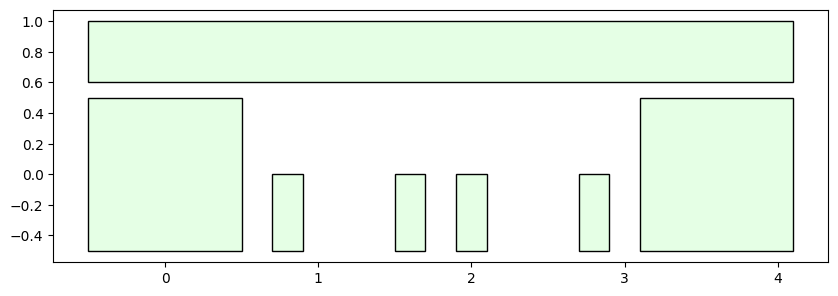

In [5]:
Terrain([1, 0, 1, 1, 0, 1]).plot()

## Transcription to a Graph of Convex Sets

Now that we have defined functions that build a terrain of rectangular stepping stones, it is time to construct the graph of convex sets (GCS). For simplicity, we assume that the robot always starts by moving its right foot (at step 0, left foot is stationary), and we also assume the step sequence alternates between two feet. Therefore, the foot sequence is fixed: {Right, Left, Right ...}. Under these assumptions, the footstep planning task is reduced to finding a path that connects the starting position $x_s \in \mathbb{R}^2$ (center of "initial" stone) to the goal position $x_t\in \mathbb{R}^2$ (center of "goal" stone) through a sequence of points $\{x_k\}_{k=1}^N$ ($N$ is the total number of steps) where each point lies within an available stepping stones.

**Add Vertices**

Let's begin by defining vertices of the GCS. Notice that each stepping stone is a rectangle, which is a convex set. Following that idea, the convex sets, or the vertices, in GCS include: all stepping stones; and the source and the target sets. The source and the target sets correspond to point sets (singleton) that include the starting position $x_s$ and goal position $x_t$, respectively.


Due to kinematic constraints, at every time step, one foot has to be within a square centered at the other foot, i.e., $$\forall k = 1, 2, ..., N-1, |x_k[0] - x_{k+1}[0]|\leq d/2, |x_k[1] - x_{k+1}[1]|\leq d/2$$ where $d$ is the `step_span`. Therefore, it is possible that the robot has to step on the same stepping stone more than once. For example, consider the above terrain, if the robot walks across the "lateral" stone with a small `step_span`, it might take multiple steps to get across.

However in GCS, constructing a single vertex for a single stone would not allow multiple $x_k$ to exist on that single stone. Therefore, suppose we want to have positions of multiple steps on the same stone, e.g., $x_k, x_{k+1}, x_{k+2} \in S_i$, these variables cannot share the same convex set. To accomodate for such requirements, we need to make copies of the same convex sets to create multiple continuous decision variables. Specifically, we make `m` copies of the same stone where `m = floor(stone_horizontal_length/step_span) + 2`. (Reasons for choosing this number is explained below the vertex naming convention)

To summarize, the vertices need to include:
1. `source` and `target` singleton sets.
2. `m` copies of each stepping stone rectangle as convex sets.


P.s. Try to use the naming convention suggested by the following code block, which names a stepping stone vertex as `xi_ii`.
- `x` is the stone type: `l` for the lateral stone, `s` for stone named "start", `t` for stone named "final", `b` for stone whose names contain "bridge"
- `i` is the index of the convex set in vertex list `V`
- `ii` is the index of the copy of the same stone

**Add Edges between vertices that are multiple copies of same set**

In addition to adding vertices, the following function also constructs edges between copies of the same stone. Since the only purpose of the copies is to provide multiple position variables inside the same set, we can define a fixed order of these copies, namely `xi_0 -> xi_1 -> ... -> xi_m`. For minimum number of steps (or minimum distance of edges on the path), the robot will only step on the same stone multiple times consecutively (not coming back to a stone once it leaves said stone). The choice of `m` ensures that even for a narrow stone where `m = 0 + 2`, the robot has the ability to place both feet on the stone so that it can position itself better to reach the next stone if needed. Additionally, if the robot needs to get across a wider stone in several steps, minimum number of steps require the robot to take as large step as possible, therefore, `m = floor(stone_horizontal_length/step_span)+2`. It is easier to add these edges while creating vertices, as demonstrated by the code template implemented for the "lateral" stone.

**You will need to implement (marked with `TODO: MODIFY HERE`):**
- Compute number of copies needed for each stone (note that start and final stones are same size)
- Add vertex for copies of convex sets corresponding to "start", "final", "bridge" stones
- Add fixed order edges between copies of the same stone

*PLEASE NOTE*: throughout this problem, "start" and "final" will refer to stones, while "source" and "target" will refer to GCS vertices and the corresponding vertex sets.

In [6]:
def add_vertex_and_edges_for_set_copies(G, T, step_span):
    start_position = tuple(T.get_stone_by_name("initial").center)
    end_position = tuple(T.get_stone_by_name("goal").center)

    V = []  # vertices
    E_list = (
        []
    )  # list of pair of vertices that can construct an edge e.g. E_list[i] = [u_i, v_i] where u_i -> v_i is a valid edge

    V.append(G.AddVertex(Point(start_position), "source"))
    V.append(G.AddVertex(Point(end_position), "target"))

    # compute number of copies needed for each vertex
    num_copy_lateral = 0  # TODO: MODIFY HERE
    num_copy_s_t = 0  # TODO: MODIFY HERE
    num_copy_bridge = 0  # TODO: MODIFY HERE

    for i, stone in enumerate(T.stepping_stones):
        H_i = HPolyhedron(stone.A, stone.b)
        if stone.name == "lateral":
            for ii in range(num_copy_lateral):
                V.append(G.AddVertex(H_i, f"l{i}_{ii}"))
                if ii > 0:
                    # add edge from parent to copy
                    E_list.append([V[-2], V[-1]])
        elif stone.name == "start":
            # TODO: MODIFY HERE
            continue
        elif stone.name == "final":
            # TODO: MODIFY HERE
            continue
        else:
            # TODO: MODIFY HERE
            continue

    return G, V, E_list

In [7]:
def add_vertex_and_edges_for_set_copies(G, T, step_span):
    start_position = tuple(T.get_stone_by_name("initial").center)
    end_position = tuple(T.get_stone_by_name("goal").center)

    V = []  # vertices
    E_list = (
        []
    )  # list of pair of vertices that can construct an edge e.g. E_list[i] = [u_i, v_i] where u_i -> v_i is a valid edge

    V.append(G.AddVertex(Point(start_position), "source"))
    V.append(G.AddVertex(Point(end_position), "target"))

    # compute number of copies needed for each vertex
    num_copy_lateral = int(
        np.floor(T.get_stone_by_name("lateral").width / step_span) + 2
    )
    num_copy_s_t = int(
        np.floor(T.get_stone_by_name("initial").width / step_span) + 2
    )
    num_copy_bridge = int(
        np.floor(T.get_stone_by_name("bridge_0").width / step_span) + 2
    )

    for i, stone in enumerate(T.stepping_stones):
        H_i = HPolyhedron(stone.A, stone.b)
        if stone.name == "lateral":
            for ii in range(num_copy_lateral):
                V.append(G.AddVertex(H_i, f"l{i}_{ii}"))
                if ii > 0:
                    # add edge from parent to copy
                    E_list.append([V[-2], V[-1]])
        elif stone.name == "start":
            for ii in range(num_copy_s_t):
                V.append(G.AddVertex(H_i, f"s{i}_{ii}"))
                if ii > 0:
                    # add edge from parent to copy
                    E_list.append([V[-2], V[-1]])
        elif stone.name == "final":
            for ii in range(num_copy_s_t):
                V.append(G.AddVertex(H_i, f"f{i}_{ii}"))
                if ii > 0:
                    # add edge from parent to copy
                    E_list.append([V[-2], V[-1]])
        else:
            for ii in range(num_copy_bridge):
                V.append(G.AddVertex(H_i, f"b{i}_{ii}"))
                if ii > 0:
                    # add edge from parent to copy
                    E_list.append([V[-2], V[-1]])

    return G, V, E_list

Now that we have constructed vertices and edges in between vertices that are copies of the same set, we need to construct the rest of edges in the GCS. The simplest brute-force approach is to connect any pair of vertices, however, we should always avoid adding redundant edges to reduce complexity of the graph.

You need to implement construction of edges based on pair of vertices `excluding` the following:

- Since we have specified a fixed order for the copies of the same set, `xi_0 -> xi_1 -> xi_2 ...`, we would avoid constructing edges that connect copies other than the fixed order, e.g., `xi_0 -> xi_2` should be avoided.

- Without loss of generality, we can enforce the planner to use the copies of the same set in a consecutive manner. Any incoming edge from vertices corresponding to different stepping stones, should only connect to the parent vertex for a given stepping stone, i.e., we only need `xj_jj -> xi_0` and do not need `xj_jj -> xi_ii` where ``ii>0``.

- In addition, `target` vertex should only have incoming edges while `source` vertex should only have outgoing edges.

Note that so far we are only constructing a list of edge vertex pairs, namely, the elements in `E_list` would be `[u, v]` where `u` and `v` are vertices. `E_list[i]` would be a list instead of a true edge class instance in the GCS class.

P.s. `[u, v]` consists of left (source) vertex `u` and right (target) vertex `v`. Suppose `u` has name '`xi_ii`', you can use `u.name().split("_")` to extract a list of strings `['xi', 'ii']`

In [8]:
def add_edges_towards_parent_vertices(G, V, E_list):
    for u in V:
        # TODO: MODIFY HERE
        # Below is an example of connecting "source" directly to "target". This is for the purpose of running the empty notebook, you should implement the edge construction as instructed above, and rewrite the codes below.

        if u.name() == "source":
            for v in V:
                if v.name() == "target":
                    E_list.append([u, v])

    return G, E_list

In [9]:
def add_edges_towards_parent_vertices(G, V, E_list):
    for u in V:
        if u.name() == "target":
            continue
        for v in V:
            if u.name() == v.name():
                continue
            if v.name() == "source":
                continue
            # Don't connect between copies of the same stone (the only edges are added above)
            # if u.name().split("_")[0] == v.name().split("_")[0] and int(u.name().split("_")[1]) != int(v.name().split("_")[1])-1:
            if u.name().split("_")[0] == v.name().split("_")[0]:
                continue
            # Only connect *to* the first copy.
            if (
                len(v.name().split("_")) == 2
                and v.name().split("_")[-1] != "0"
            ):
                continue
            E_list.append([u, v])

    return G, E_list

Now that we have constructed a list `E_list` whose elements are `[u, v]`, vertex pairs of all valid edges, we are ready to add Edges in the Graph, along with their constraints and costs.

You will need to implement edge constraints and costs in the following block ((marked with `TODO: MODIFY HERE`)):

Constraints:
- For every vertex pair (ordered) `[u, v]` in `E_list`, we use `e = G.AddEdge(u, v)` to first construct an edge.
- For each edge `e`, the continuous variables (check [documentation](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1optimization_1_1_graph_of_convex_sets_1_1_edge.html) for syntax) xu and xv must satisfy the kinematic constraint. Namely, $x_u, x_v \in \mathbb{R}^2$, $\|x_u - x_v\|_{\infty} \leq d/2$ where `d = step_span`.

Costs:

In this problem, we consider a minimum number of step as the overall cost function. Therefore, each edge `e` is associated with a constant cost, e.g. 1. . Use `e.AddCost()` for implementation, for details please see [documentation](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1optimization_1_1_graph_of_convex_sets_1_1_edge.html)

Remark: edge costs in GCS can be very general and suit a variety of motion planning tasks, e.g., L-2 norm of $x_u-x_v$. Here we stick with a constant edge cost because this makes the resulting convex program easy to solve, allowing us to use `SnoptSolver()` provided by drake. For more general cost function such as L-2 norm, commercial optimization solvers such as `MosekSolver()` and `GurobiSolver()` are more reliable in generating good numerical results.

In [10]:
def add_edge_constraints_costs(G, E_list, step_span):
    E = []

    for u, v in E_list:
        e = G.AddEdge(u, v)

        # TODO: MODIFY HERE
        # Add kinematic constraints to the edges

        # TODO: MODIFY HERE
        # Add constant edge cost

        E.append(e)

    return G, E

In [11]:
def add_edge_constraints_costs(G, E_list, step_span):
    E = []

    for u, v in E_list:
        e = G.AddEdge(u, v)
        # Add kinematic constraints to the edges
        e.AddConstraint(e.xu()[0] - e.xv()[0] <= step_span / 2)
        e.AddConstraint(e.xv()[0] - e.xu()[0] <= step_span / 2)
        e.AddConstraint(e.xu()[1] - e.xv()[1] <= step_span / 2)
        e.AddConstraint(e.xv()[1] - e.xu()[1] <= step_span / 2)

        # Add Euclidean distance squared as edge cost
        # e.AddCost((e.xu() - e.xv()).dot(e.xu() - e.xv()))
        e.AddCost(1.0)
        # Add edge object to the graph
        E.append(e)

    return G, E

Now we have all the components of a GCS, we are ready to solve the SPP in GCS. Note that in drake, the solution to GCS is an instance of [`MathematicalProgramResult()`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1solvers_1_1_mathematical_program_result.html). In this case, using convex relaxation, the result will contain numerical solutions for decision variables including: continuous variable in each vertex and edge flow variables. The edge flow variables `e.phi()` is a continuous variable between 0 and 1, which is a relaxed version of binary variable that takes value 0 or 1. In the solution, if the binary variable value is 1, it means the edge is active in the path. In our problem, the convex relaxation is very tight, the continuous flow variables in the solution only take binary values 0 and 1.

Before we construct the GCS footstep planner, below are two helper functions that extract the planned footstep position from the GCS solution: `extract_path()` and `footstep2position()`.

- Using the edge flow variable values in the solution, we can check whether an edge appears in the optimal path. When the flow variables take binary values, `extract_path()` uses the fact that each vertex should only have one outgoing edge that has flow variables `phi()=1` to extract the path. More generally, depth first search can be used to extract a path from solution with non-binary flow variable values.

- `extract_path()` returns `path_position`, which is a numpy array of size `n_steps, 2` and for step i `path_position[i]` is the `x-y` position of the moving foot. Under this specific sequence, Recall that our planner assumes a fixed foot sequence {Right, Left, Right, ...}. Given the moving foot position sequence, we can reconstruct the position of left and right foot over the `n_steps`: As an example, if at step `i`, left foot is moving, then `position_left[i+1] = path_position[i+1]` and `position_right[i+1] = position_right[i]`.

In [12]:
def extract_path(V, E, result):
    V_dict = {}
    for i, v in enumerate(V):
        V_dict[v.name()] = i

    V_adj = np.zeros((len(V), len(V)))

    for e in E:
        if result.GetSolution(e.phi()):
            u_index = V_dict[e.u().name()]
            v_index = V_dict[e.v().name()]
            V_adj[u_index, v_index] = 1

    path = ["source"]
    path_count = 0
    while path[-1] != "target":
        u_name = path[-1]
        v_index = np.where(V_adj[V_dict[u_name], :] == 1)[0][0]
        path.append(V[v_index].name())
        path_count = path_count + 1
        if path_count > 100:
            print("Abort path extraction: possible loops")
            break

    path_position = np.zeros((len(path), 2))
    for i in range(len(path)):
        path_position[i, :] = result.GetSolution(V[V_dict[path[i]]].x())

    return path, path_position


def footstep2position(planner_footstep):
    # For now assume left foot is initially at [0.,0.] and always move right foot first
    n_steps = planner_footstep.shape[0]
    position_left = np.zeros((n_steps, 2))
    position_right = np.zeros((n_steps, 2))
    position_right[0, :] = np.array([0.0, -0.2])

    for i in range(n_steps):
        if i % 2 == 0:
            # odd steps: right foot stationary, assign value to left foot
            position_left[i, :] = planner_footstep[i, :]
            if i > 0:
                position_right[i, :] = position_right[i - 1, :]
        else:
            # even steps: left foot stationary, assign value to right foot
            position_right[i, :] = planner_footstep[i, :]
            position_left[i, :] = position_left[i - 1, :]
    return position_left, position_right

With the above two helper functions, we are finally ready to construct the GCS footstep planner! In the following cell, we put together all the pieces we wrote so far to formulate the GCS, set up several key options in the GCS solver, and solve for the optimal path.

In [13]:
def GCS_footstep_planner(T, step_span, convex_relaxation, solver):
    # Initial GCS problem
    G = GraphOfConvexSets()

    # Add vertices and edges
    G, V, E_list = add_vertex_and_edges_for_set_copies(G, T, step_span)
    G, E_list = add_edges_towards_parent_vertices(G, V, E_list)

    # Add edge constraints and costs
    G, E = add_edge_constraints_costs(G, E_list, step_span)

    # solve the shortest path problem on GCS
    options = GraphOfConvexSetsOptions()
    options.preprocessing = True
    options.max_rounded_paths = 10
    options.convex_relaxation = convex_relaxation
    options.solver = solver
    result = G.SolveShortestPath(V[0], V[1], options)

    path, path_position = extract_path(V, E, result)
    # minimum number of steps cost
    path_cost = len(path) - 1
    # Convert path_position to left and right foot position
    position_left, position_right = footstep2position(path_position)

    return position_left, position_right, path_cost

## Animate the solution of the SPP in GCS

Here is a wrapper function that completes both footstep planning and animating the planned steps on a given terrain. If you are curious about how to implement such an anmiation, feel free to check the helper function `animate_footstep_plan()` in the `footstep_planning_gcs_utils.py` file.

In [14]:
def generate_and_animate_footstep_plan(
    terrain, step_span, convex_relaxation, solver, title=None
):
    # run footstep planner
    position_left, position_right, path_cost = GCS_footstep_planner(
        terrain, step_span, convex_relaxation, solver
    )

    # animate result
    animate_footstep_plan(
        terrain, step_span, position_left, position_right, title
    )

    return position_left, position_right, path_cost

## Try the Footstep Planner on two Terrains

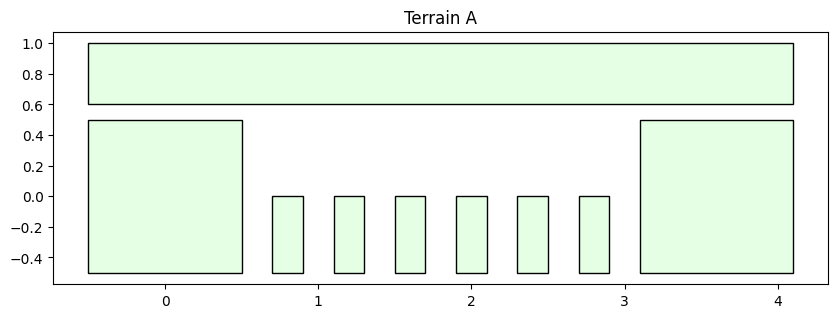

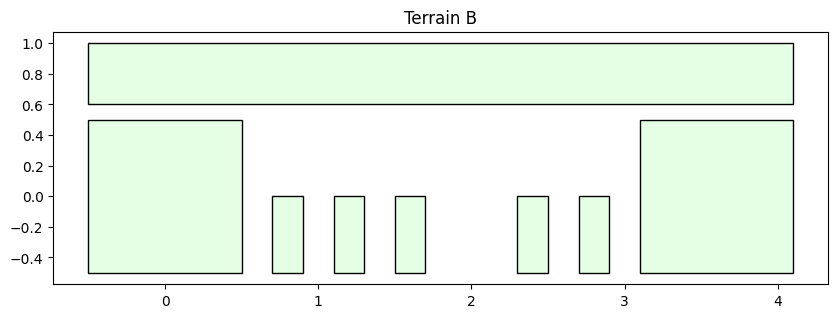

In [15]:
# complete bridge
terrain_A = Terrain([1, 1, 1, 1, 1, 1])
terrain_A.plot("Terrain A")
plt.show()

# one stepping stone missing in the bridge
terrain_B = Terrain([1, 1, 1, 0, 1, 1])
terrain_B.plot("Terrain B")
plt.show()

In [16]:
step_span = 0.8
convex_relaxation = True

solver = SnoptSolver()

position_left_A, position_right_A, cost_A = generate_and_animate_footstep_plan(
    terrain_A, step_span, convex_relaxation, solver
)
position_left_B, position_right_B, cost_B = generate_and_animate_footstep_plan(
    terrain_B, step_span, convex_relaxation, solver
)

INFO:drake:Solved GCS shortest path using SNOPT with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.


INFO:drake:Solved GCS shortest path using SNOPT with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.


## Autograding

You can check your work by running the following cell.

In [17]:
Grader.grade_output([TestFootstepPlanning], [locals()], "results.json")
Grader.print_test_results("results.json")

INFO:drake:Solved GCS shortest path using SNOPT with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.
INFO:drake:Solved GCS shortest path using SNOPT with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.
INFO:drake:Solved GCS shortest path using SNOPT with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.
INFO:drake:Solved GCS shortest path using SNOPT with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.


Total score is 16/16.

Score for Tests that the positioning of the feet minimized the sum of the is 8/8.

Score for Tests the constraints on the relative position of the feet is 8/8.
